## Programming Exercise 2 - Logistic Regression

- [Logistic regression](#Logistic-regression)
- [Regularized logistic regression](#Regularized-logistic-regression)

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [2]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

In [3]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

### Logistic regression

In [5]:
data = loaddata('data/ex2data1.txt', ',')

Dimensions:  (100, 3)
[[30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]]


In [8]:
X = np.c_[np.ones((data.shape[0],1)), data[:,0:2]]
y = np.c_[data[:,2]]

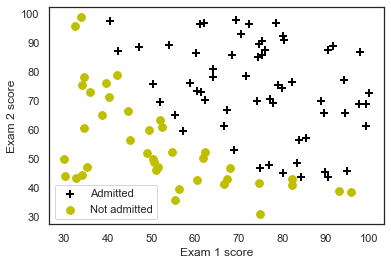

In [7]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [11]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

Scipy actually has a convenience function which does exactly the same:<BR>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit

#### Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$

In [12]:
def costFunction(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))
               
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

#### Partial derivative

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 
#### Vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$


In [13]:
def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    
    grad =(1/m)*X.T.dot(h-y)

    return(grad.flatten())

In [14]:
initial_theta = np.zeros(X.shape[1])
cost = costFunction(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print('Cost: \n', cost)
print('Grad: \n', grad)

Cost: 
 0.6931471805599452
Grad: 
 [ -0.1        -12.00921659 -11.26284221]


#### Optimize cost function

In [15]:
res = minimize(costFunction, initial_theta, args=(X,y), method=None, jac=gradient, options={'maxiter':400})
res

E:\Users\Basharat\Anaconda3\envs\Bash\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
E:\Users\Basharat\Anaconda3\envs\Bash\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


      fun: 0.20349770158950983
 hess_inv: array([[ 2.85339493e+03, -2.32908823e+01, -2.27416470e+01],
       [-2.32908823e+01,  2.04489131e-01,  1.72969525e-01],
       [-2.27416470e+01,  1.72969525e-01,  1.96170322e-01]])
      jac: array([-2.68557631e-09,  4.36433478e-07, -1.39671758e-06])
  message: 'Optimization terminated successfully.'
     nfev: 34
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([-25.16131634,   0.2062316 ,   0.20147143])

#### Predict

In [16]:
def predict(theta, X, threshold=0.5):
    p = sigmoid(X.dot(theta.T)) >= threshold
    return(p.astype('int'))

In [17]:
# Student with Exam 1 score 45 and Exam 2 score 85
# Predict using the optimized Theta values from above (res.x)
sigmoid(np.array([1, 45, 85]).dot(res.x.T))

0.7762903249331015

In [18]:
p = predict(res.x, X) 
print('Train accuracy {}%'.format(100*sum(p == y.ravel())/p.size))

Train accuracy 89.0%


#### Decision boundary

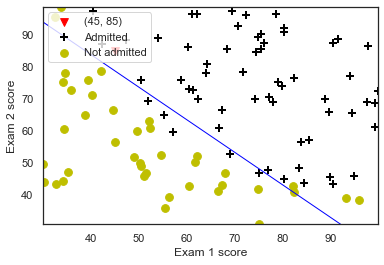

In [19]:
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');

### Regularized logistic regression

In [20]:
data2 = loaddata('data/ex2data2.txt', ',')

Dimensions:  (118, 3)
[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


In [21]:
y = np.c_[data2[:,2]]
X = data2[:,0:2]

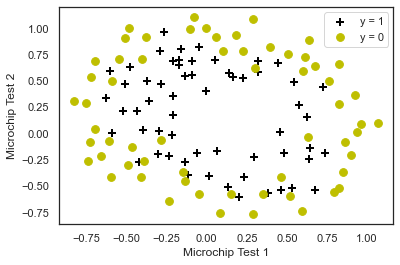

In [22]:
plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

#### Polynomials

In [23]:
# Note that this function inserts a column with 'ones' in the design matrix for the intercept.
poly = PolynomialFeatures(6)
XX = poly.fit_transform(data2[:,0:2])
XX.shape

(118, 28)

#### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [24]:
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

#### Partial derivative

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### Vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [25]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [26]:
initial_theta = np.zeros(XX.shape[1])
costFunctionReg(initial_theta, 1, XX, y)

0.6931471805599453

E:\Users\Basharat\Anaconda3\envs\Bash\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


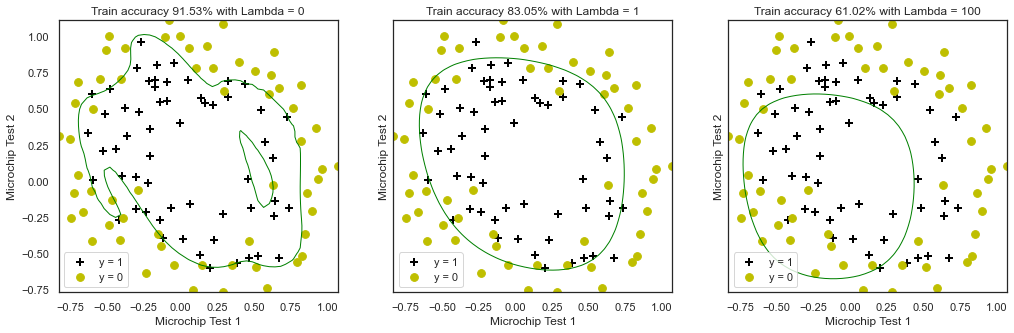

In [27]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias

for i, C in enumerate([0, 1, 100]):
    # Optimize costFunctionReg
    res2 = minimize(costFunctionReg, initial_theta, args=(C, XX, y), method=None, jac=gradientReg, options={'maxiter':3000})
    
    # Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size    

    # Scatter plot of X,y
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Plot decisionboundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))